In [211]:
# Kaggle Mohs Regression Analysis

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import pprint
import joblib
from time import time
from functools import partial


# Model Selection
from sklearn.model_selection import train_test_split, cross_val_predict, cross_val_score, KFold, StratifiedKFold

# Feature Exploration
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.spatial.distance import squareform

# Data Processing
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OrdinalEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer


# Classifier/Regressor
from xgboost import XGBRegressor, DMatrix

# Metrics
from sklearn.metrics import mean_squared_error
from sklearn.metrics import make_scorer
from sklearn.metrics import median_absolute_error

# Skopt functions
from skopt import BayesSearchCV
from skopt.callbacks import DeadlineStopper, DeltaYStopper
from skopt.space import Real, Categorical, Integer

# Suppressing warnings because of skopt verbosity
import warnings
warnings.filterwarnings("ignore")

# Set Seed Value
random_state = 4444

In [212]:
full_train = pd.read_csv('train.csv')
full_test = pd.read_csv('test.csv')

In [213]:
full_train.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average,Hardness
0,0,100.0,0.841611,10.0,4.8,20.612526,11.08810,2.766,1.732,0.860,0.496070,0.91457,6.0
1,1,100.0,7.558488,10.0,4.8,20.298893,12.04083,2.755,1.631,0.910,0.492719,0.71760,6.5
2,2,76.0,8.885992,15.6,5.6,33.739258,12.08630,2.828,1.788,0.864,0.481478,1.50633,2.5
3,3,100.0,8.795296,10.0,4.8,20.213349,10.94850,2.648,1.626,0.936,0.489272,0.78937,6.0
4,4,116.0,9.577996,11.6,4.8,24.988133,11.82448,2.766,1.682,0.896,0.492736,1.86481,6.0


In [214]:
full_test.head()

,id,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,atomicweight_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
0,10407,884.0,121.420000,35.36,5.28,82.561240,9.370384,2.298,1.9072,1.200000,0.461899,1.79459
1,10408,90.0,9.931960,18.00,5.60,39.568056,12.086300,2.868,1.6520,0.864000,0.476196,1.41194
2,10409,116.0,7.767992,11.60,4.80,23.231818,11.023840,2.644,1.7940,0.960000,0.499514,0.78834
3,10410,100.0,9.107996,10.00,4.80,20.298893,12.086300,2.828,1.6620,0.792000,0.495796,1.20466
4,10411,55.0,4.030000,11.00,4.00,22.977675,11.280950,2.455,1.7500,0.893333,0.476095,0.93456


## Considerations

The training set contains both the ID and the Hardness, whereas the test set does not have the hardness. We will have to create our own Train-Test sets for model validation.  

In [215]:
full_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10407 entries, 0 to 10406
Data columns (total 13 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     10407 non-null  int64  
 1   allelectrons_Total     10407 non-null  float64
 2   density_Total          10407 non-null  float64
 3   allelectrons_Average   10407 non-null  float64
 4   val_e_Average          10407 non-null  float64
 5   atomicweight_Average   10407 non-null  float64
 6   ionenergy_Average      10407 non-null  float64
 7   el_neg_chi_Average     10407 non-null  float64
 8   R_vdw_element_Average  10407 non-null  float64
 9   R_cov_element_Average  10407 non-null  float64
 10  zaratio_Average        10407 non-null  float64
 11  density_Average        10407 non-null  float64
 12  Hardness               10407 non-null  float64
dtypes: float64(12), int64(1)
memory usage: 1.0 MB


In [216]:
full_train.columns.to_list()

['id',
 'allelectrons_Total',
 'density_Total',
 'allelectrons_Average',
 'val_e_Average',
 'atomicweight_Average',
 'ionenergy_Average',
 'el_neg_chi_Average',
 'R_vdw_element_Average',
 'R_cov_element_Average',
 'zaratio_Average',
 'density_Average',
 'Hardness']

## Features

id: Unique sample identifier<br>
allelectrons_Total: Total number of electrons in the compound<br> 
allelectrons_Average: Average number of electrons present in the sample<br>
density_Total: Total density of the sample *(kg/m<sup>3</sup>)*<br>
density_Average': Average elemental density *(kg/m<sup>3</sup>)*<br>
R_vdw_element_Average: Van der Waals Radius - half distance between like atoms that are non-bonded *(m)*<br>
R_cov_element_Average: Covelant Bond Radius - half distance between like atomic nuclei that are covelantly bonded *(m)*<br>
val_e_Average: Average number of valence outer shell electrons <br>
atomicweight_Average: Average Atomic Weight of the sample compound<br> 
ionenergy_Average: Average first ionization energy - to bump a valence electron into the next shell<br>
el_neg_chi_Average: Pauling electronegativity of the most common oxidation state (changes with transition metal-containing compounds)<br>
zaratio_Average: The ratio of electron density to bulk density, determined by the average atomic number / average atomic weight<br>
Hardness: Mohs Hardness rating

In [217]:
full_train.isna().sum()

id                       0
allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
Hardness                 0
dtype: int64

In [218]:
full_test.isna().sum()

id                       0
allelectrons_Total       0
density_Total            0
allelectrons_Average     0
val_e_Average            0
atomicweight_Average     0
ionenergy_Average        0
el_neg_chi_Average       0
R_vdw_element_Average    0
R_cov_element_Average    0
zaratio_Average          0
density_Average          0
dtype: int64

In [219]:
print(f' There are {len(full_train)} rows in the full_train dataset.')

 There are 10407 rows in the full_train dataset.


In [220]:
print(f' There are {len(full_test)} rows in the full_train dataset.')

 There are 6939 rows in the full_train dataset.


In [221]:
# Check for duplicates
full_train.drop(['id'], axis=1)
dupes = full_train[full_train.duplicated()]

full_test.drop(['id'], axis=1)
dupest = full_test[full_test.duplicated()]

print(f' There are {len(dupes)} duplicates in the full_train dataset and {len(dupest)} duplicates in the full_test dataset.')

 There are 0 duplicates in the full_train dataset and 0 duplicates in the full_test dataset.


# Define Functions for Analysis

In [222]:
# Heatmap function that does not duplicate relationships

def heatmap(dataset, label = None):
    columns = list(dataset)
    corr = dataset.corr()
    plt.figure(figsize = (14, 10))
    mask = np.zeros_like(corr)
    mask[np.triu_indices_from(mask)] = True
    sns.heatmap(corr, mask = mask, cmap = 'crest', annot = True, linewidths = .1)
    #plt.yticks(range(len(columns)), columns, fontsize = 5)
    #plt.xticks(range(len(columns)), columns, fontsize = 5)
    plt.title(f'{label} Dataset Correlation Matrix\n', fontsize = 25, weight = 'bold')
    plt.show()

In [223]:
def distance(data, label = ''):
    #thanks to @sergiosaharovsky for the fix
    corr = data.corr(method = 'spearman')
    dist_linkage = linkage(squareform(1 - abs(corr)), 'complete')
    
    plt.figure(figsize = (10, 8))
    dendro = dendrogram(dist_linkage, labels=data.columns, leaf_rotation=90, )
    plt.title(f'Feature Distance in {label} Dataset', weight = 'bold', size = 22)
    plt.show()

In [224]:
# Reporting util for different optimizers

def report_perf(optimizer, X, y, title="model", callbacks=None):
    """
    A wrapper for measuring time and performances of different optmizers
    
    optimizer = a sklearn or a skopt optimizer
    X = the training set 
    y = our target
    title = a string label for the experiment
    """
    start = time()
    
    if callbacks is not None:
        optimizer.fit(X, y, callback=callbacks)
    else:
        optimizer.fit(X, y)
        
    d=pd.DataFrame(optimizer.cv_results_)
    best_score = optimizer.best_score_
    best_score_std = d.iloc[optimizer.best_index_].std_test_score
    best_params = optimizer.best_params_
    
    print((title + " took %.2f seconds,  candidates checked: %d, best CV score: %.3f "
           + u"\u00B1"+" %.3f") % (time() - start, 
                                   len(optimizer.cv_results_['params']),
                                   best_score,
                                   best_score_std))    
    print('Best parameters:')
    pprint.pprint(best_params)
    print()
    return best_params

In [225]:
X = full_train.set_index('id').drop(['Hardness'
                                     , 'atomicweight_Average']
                                    , axis=1)
y = full_train.Hardness

In [226]:
y.value_counts()

6.00     2063
5.50     1463
2.50     1089
3.80      712
5.80      403
6.50      397
2.00      388
2.80      387
5.00      375
4.00      370
3.00      310
2.30      292
6.30      266
3.50      261
6.80      240
1.50      174
1.80      158
3.30      144
5.30      135
4.30      130
4.80      105
7.50       98
4.50       97
7.00       96
7.80       64
9.00       33
10.00      30
9.50       25
1.30       18
8.50       15
8.00       12
5.75       10
6.20       10
7.30       10
8.10        7
2.90        5
1.00        2
2.20        1
5.40        1
6.70        1
2.60        1
3.60        1
8.30        1
4.10        1
3.20        1
4.70        1
6.40        1
9.80        1
2.10        1
6.64        1
Name: Hardness, dtype: int64

In [227]:
X.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
id,,,,,,,,,,
0,100.0,0.841611,10.0,4.8,11.08810,2.766,1.732,0.860,0.496070,0.91457
1,100.0,7.558488,10.0,4.8,12.04083,2.755,1.631,0.910,0.492719,0.71760
2,76.0,8.885992,15.6,5.6,12.08630,2.828,1.788,0.864,0.481478,1.50633
3,100.0,8.795296,10.0,4.8,10.94850,2.648,1.626,0.936,0.489272,0.78937
4,116.0,9.577996,11.6,4.8,11.82448,2.766,1.682,0.896,0.492736,1.86481


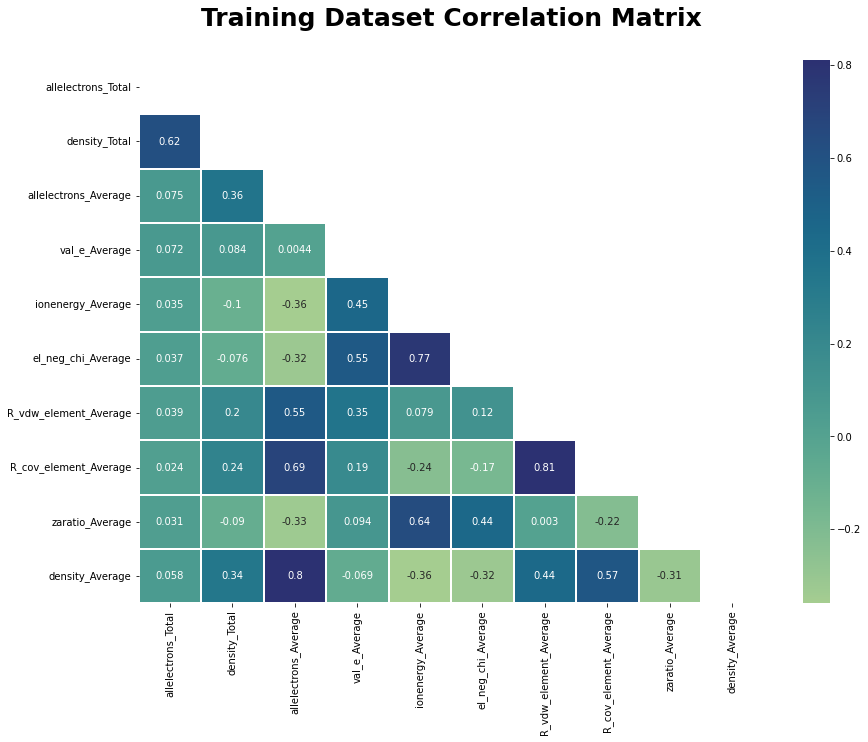

In [228]:
heatmap(X, 'Training')

The Atomic Weight and Electron Average have a 0.99 correlation, which is not surprising, as the number of electrons is nearly determined by the atomic number. Furthermore, the atomic weight average and the all_electrons average continue to show similar correlations with other parameters throughout. We will be removing the atomic weight average. 

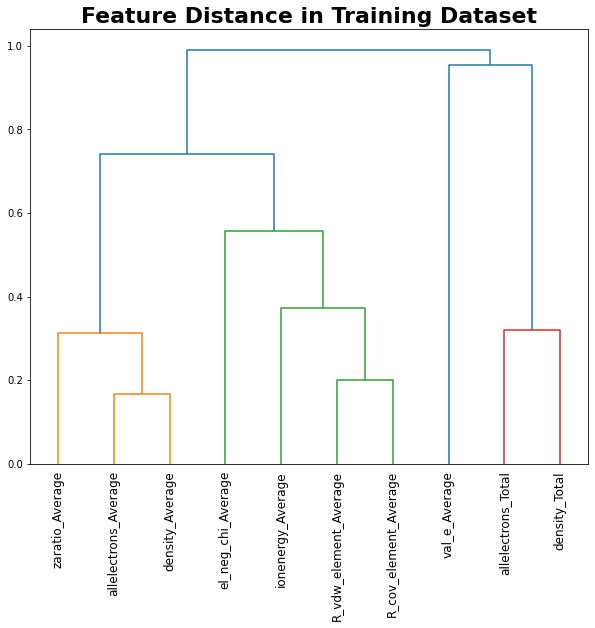

In [229]:
distance(X, "Training")

## Next Steps

In [230]:
# Create training and validation sets
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=0.8, test_size=0.2, random_state=random_state)

In [231]:
X_train.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
id,,,,,,,,,,
4202,146.0,9.143996,13.60,4.000,11.909720,2.8840,1.662000,0.78200,0.490932,1.86481
5361,126.0,13.385996,25.20,5.600,11.614220,2.8840,1.736000,0.94400,0.467568,2.28126
5623,112.0,14.883996,16.50,4.500,10.499400,2.2950,1.908000,1.12000,0.482036,1.01032
92,347.0,32.735400,42.25,5.375,9.370384,2.5300,1.815313,1.01125,0.439165,5.56317
4725,90.0,3.550000,10.00,5.000,10.999625,2.7275,1.765000,0.94500,0.499514,0.59237


In [232]:
X_test.head()

,allelectrons_Total,density_Total,allelectrons_Average,val_e_Average,ionenergy_Average,el_neg_chi_Average,R_vdw_element_Average,R_cov_element_Average,zaratio_Average,density_Average
id,,,,,,,,,,
7028,36.0,3.550000,18.000000,4.000000,8.213150,1.950000,2.040000,1.410000,0.499000,1.76405
6554,70.0,9.133000,20.000000,4.000000,10.599905,2.135000,1.905000,1.130000,0.447885,1.35130
3877,58.0,17.053984,19.333333,5.333333,11.360000,2.826667,1.716667,0.901667,0.487833,1.50857
2057,20.0,0.973995,10.000000,4.800000,10.938950,2.675000,1.745000,0.920000,0.489272,0.83154
6786,522.0,121.420000,48.280000,5.280000,9.370384,2.298000,1.907200,1.200000,0.461899,6.52300


In [233]:
y_train.head()

4202    3.8
5361    2.3
5623    6.3
92      3.5
4725    6.0
Name: Hardness, dtype: float64

In [234]:
y_test.head()

7028    4.0
6554    3.8
3877    5.8
2057    6.8
6786    2.0
Name: Hardness, dtype: float64

In [235]:
# Stratify the Target
y_stratified = pd.cut(y_train.rank(method='first'), bins=10, labels=False)

In [236]:
# Winsorizing lower bounds
from scipy.stats.mstats import winsorize
y_train = np.array(winsorize(y_train, [0.002, 0.0]))

In [237]:
# Set up the scoring function
scoring = make_scorer(partial(median_absolute_error), greater_is_better=False)


In [238]:
# Set the validation strategy
skf = StratifiedKFold(n_splits=7
                      , shuffle=True 
                      , random_state=random_state)

cv_strategy = list(skf.split(X_train, y_stratified))

In [239]:
# Setting the basic regressor
reg = XGBRegressor(random_state=random_state
                   , booster='gbtree'
                   , objective='reg:squarederror'
                   , eval_metric='mae'
                   , tree_method='gpu_hist')

In [240]:
# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform')
                 , 'max_depth': Integer(2, 12)
                 , 'subsample': Real(0.1, 1.0, 'uniform')
                 , 'colsample_bytree': Real(0.1, 1.0, 'uniform') # subsample ratio of columns by tree
                 , 'reg_lambda': Real(1e-9, 100., 'uniform') # L2 regularization
                 , 'reg_alpha': Real(1e-9, 100., 'uniform') # L1 regularization
                 , 'n_estimators': Integer(50, 5000)
   }

In [241]:
# Wrap everything up into the Bayesian Optimizer
opt = BayesSearchCV(estimator=reg
                    , search_spaces=search_spaces
                    , scoring=scoring
                    , cv=cv_strategy
                    , n_iter=120                                    # max number of trials
                    , n_points=1                                    # number of hyperparameter sets eval at same time
                    , n_jobs=1                                      
                    , iid=False                                     # if not iid, optimizes on the cv score
                    , return_train_score=False
                    , refit=False
                    , optimizer_kwargs={'base_estimator': 'GP'}     # Gaussian Process optimizeer parameters
                    , random_state=random_state)

In [242]:
# Run the optimizer 
overdone_control = DeltaYStopper(delta=0.001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60*4)           # Impose Time limit

best_params = report_perf(opt
                          , X_train
                          , y_train
                          ,'XGBoost_regression'
                          , callbacks=[overdone_control, time_limit_control]
                          )

XGBoost_regression took 188.93 seconds,  candidates checked: 9, best CV score: -0.693 ± 0.023
Best parameters:
OrderedDict([('colsample_bytree', 0.486112904696106),
             ('learning_rate', 0.6501630000610656),
             ('max_depth', 5),
             ('n_estimators', 307),
             ('reg_alpha', 37.146135981856105),
             ('reg_lambda', 12.777179496784381),
             ('subsample', 0.9490768181659544)])



In [243]:
# Transferring the best parameters to our basic regressor
reg = XGBRegressor(random_state=random_state
                   , booster='gbtree'
                   , objective='reg:squarederror'
                   , eval_metric='mae'
                   , tree_method='gpu_hist'
                   , **best_params)

In [244]:
# # Cross-validation prediction
# folds = 10
# skf = StratifiedKFold(n_splits=folds,
#                       shuffle=True, 
#                       random_state=random_state)

# predictions = np.zeros(len(X_test))
# mae = list()

# for k, (train_idx, val_idx) in enumerate(skf.split(X_train, y_stratified)):
#     reg.fit(X_train.iloc[train_idx, :], y_train[train_idx])
#     val_preds = reg.predict(X_train.iloc[val_idx, :])
#     val_mae = median_absolute_error(y_true=y_train[val_idx], y_pred=val_preds)
#     print(f"Fold {k} MAE: {val_mae:0.5f}")
#     mae.append(val_mae)
#     predictions += reg.predict(X_test).ravel()
    
# predictions /= folds
# print(f"repeated CV MAE: {np.mean(mae):0.5f} (std={np.std(mae):0.5f})")


# Cross-validation prediction
folds = 10
skf = StratifiedKFold(n_splits=folds,
                      shuffle=True, 
                      random_state=0)

predictions = np.zeros(len(X_test))
# rmse = list()
mae = list()

for k, (train_idx, val_idx) in enumerate(skf.split(X_train, y_stratified)):
    reg.fit(X_train.iloc[train_idx, :], y_train[train_idx])
    val_preds = reg.predict(X_train.iloc[val_idx, :])
    # val_rmse = mean_squared_error(y_true=y_train[val_idx], y_pred=val_preds, squared=False)
    val_mae = median_absolute_error(y_true=y_train[val_idx], y_pred=val_preds)
    # print(f"Fold {k} RMSE: {val_rmse:0.5f}")
    print(f"Fold {k} MAE: {val_mae:0.5f}")
    # rmse.append(val_rmse)
    mae.append(val_mae)
    predictions += reg.predict(X_test).ravel()
    
predictions /= folds
# print(f"repeated CV RMSE: {np.mean(rmse):0.5f} (std={np.std(rmse):0.5f})")
print(f"repeated CV MAE: {np.mean(mae):0.5f} (std={np.std(mae):0.5f})")

Fold 0 MAE: 0.68329
Fold 1 MAE: 0.65163
Fold 2 MAE: 0.71612
Fold 3 MAE: 0.69925
Fold 4 MAE: 0.70695
Fold 5 MAE: 0.65927
Fold 6 MAE: 0.73195
Fold 7 MAE: 0.66285
Fold 8 MAE: 0.71779
Fold 9 MAE: 0.67238
repeated CV MAE: 0.69015 (std=0.02664)


In [245]:
submission = pd.DataFrame({'id': X_test.index
                           , 'Hardness': predictions})

In [246]:
submission.head()

,id,Hardness
0,7028,4.180142
1,6554,4.550743
2,3877,5.318253
3,2057,5.854910
4,6786,2.581762


In [247]:
y_test.head()

7028    4.0
6554    3.8
3877    5.8
2057    6.8
6786    2.0
Name: Hardness, dtype: float64

## Actual Test

In [258]:
X_train = full_train.set_index('id').drop(['Hardness'
                                     , 'atomicweight_Average']
                                    , axis=1)
y_train = full_train.Hardness

X_test = full_test.set_index('id').drop('atomicweight_Average', axis=1)

In [259]:
# Stratify the Target
y_stratified = pd.cut(y_train.rank(method='first'), bins=10, labels=False)

# Winsorizing lower bounds
from scipy.stats.mstats import winsorize
y_train = np.array(winsorize(y_train, [0.002, 0.0]))


# Set up the scoring function
scoring = make_scorer(partial(median_absolute_error), greater_is_better=False)


# Set the validation strategy
skf = StratifiedKFold(n_splits=7
                      , shuffle=True 
                      , random_state=random_state)

cv_strategy = list(skf.split(X_train, y_stratified))


# Setting the basic regressor
reg = XGBRegressor(random_state=random_state
                   , booster='gbtree'
                   , objective='reg:squarederror'
                #    , eval_metric='mae'
                   , tree_method='gpu_hist')


# Setting the search space
search_spaces = {'learning_rate': Real(0.01, 1.0, 'uniform')
                 , 'max_depth': Integer(2, 12)
                 , 'subsample': Real(0.1, 1.0, 'uniform')
                 , 'colsample_bytree': Real(0.1, 1.0, 'uniform') # subsample ratio of columns by tree
                 , 'reg_lambda': Real(1e-9, 100., 'uniform') # L2 regularization
                 , 'reg_alpha': Real(1e-9, 100., 'uniform') # L1 regularization
                 , 'n_estimators': Integer(50, 5000)
   }


# Wrap everything up into the Bayesian Optimizer
opt = BayesSearchCV(estimator=reg
                    , search_spaces=search_spaces
                    , scoring=scoring
                    , cv=cv_strategy
                    , n_iter=120                                    # max number of trials
                    , n_points=1                                    # number of hyperparameter sets eval at same time
                    , n_jobs=1                                      
                    , iid=False                                     # if not iid, optimizes on the cv score
                    , return_train_score=False
                    , refit=False
                    , optimizer_kwargs={'base_estimator': 'GP'}     # Gaussian Process optimizeer parameters
                    , random_state=random_state)



# Run the optimizer 
overdone_control = DeltaYStopper(delta=0.0001)                    # We stop if the gain of the optimization becomes too small
time_limit_control = DeadlineStopper(total_time=60)           # Impose Time limit

best_params = report_perf(opt
                          , X_train
                          , y_train
                          ,'XGBoost_regression'
                          , callbacks=[overdone_control, time_limit_control]
                          )





XGBoost_regression took 8982.37 seconds,  candidates checked: 120, best CV score: -0.657 ± 0.022
Best parameters:
OrderedDict([('colsample_bytree', 0.5134833581452738),
             ('learning_rate', 0.01),
             ('max_depth', 12),
             ('n_estimators', 5000),
             ('reg_alpha', 1e-09),
             ('reg_lambda', 96.97805798806588),
             ('subsample', 1.0)])



In [1]:

# Transferring the best parameters to our basic regressor
reg = XGBRegressor(random_state=random_state
                   , booster='gbtree'
                   , objective='reg:squarederror'
                   , eval_metric='mae'
                   , tree_method='gpu_hist'
                   , **best_params)

# Cross-validation prediction
folds = 10
skf = StratifiedKFold(n_splits=folds,
                      shuffle=True, 
                      random_state=0)

predictions = np.zeros(len(X_test))
# rmse = list()
mae = list()

for k, (train_idx, val_idx) in enumerate(skf.split(X_train, y_stratified)):
    reg.fit(X_train.iloc[train_idx, :], y_train[train_idx])
    val_preds = reg.predict(X_train.iloc[val_idx, :])
    # val_rmse = mean_squared_error(y_true=y_train[val_idx], y_pred=val_preds, squared=False)
    val_mae = median_absolute_error(y_true=y_train[val_idx], y_pred=val_preds)
    # print(f"Fold {k} RMSE: {val_rmse:0.5f}")
    print(f"Fold {k} MAE: {val_mae:0.5f}")
    # rmse.append(val_rmse)
    mae.append(val_mae)
    predictions += reg.predict(X_test).ravel()
    
predictions /= folds
# print(f"repeated CV RMSE: {np.mean(rmse):0.5f} (std={np.std(rmse):0.5f})")
print(f"repeated CV MAE: {np.mean(mae):0.5f} (std={np.std(mae):0.5f})")

NameError: name 'XGBRegressor' is not defined

In [261]:
submission = pd.DataFrame({'id': X_test.index
                           , 'Hardness': predictions})


submission.head()

,id,Hardness
0,10407,2.640747
1,10408,3.025310
2,10409,6.168027
3,10410,3.618680
4,10411,5.729343


In [262]:
submission.to_csv("submission.csv", index = False)